아래의 코드는 CUSUM 통계지표를 활용하여 Drift 감지를 수행합니다.

다음과 같은 단계로 이루어져 있습니다:

> 1. 필요한 라이브러리와 사용자 정의 모듈을 불러옵니다.

> 2. 데이터 파일 경로를 설정합니다.

> 3. 결과를 저장하기 위한 함수를 정의합니다.

> 4. 훈련 데이터와 테스트 데이터를 불러옵니다.

> 5. 훈련 데이터를 사용하여 Configuration을 계산하고 저장합니다.

> 6. 시험용 데이터를 사용하여 Drift Monitoring을 실행합니다.

In [1]:
# 필요한 라이브러리들을 불러옵니다.
import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm

# 상위 디렉토리로 경로를 설정합니다.
sys.path.append(os.path.abspath('../'))

# 사용자 정의 모듈을 불러옵니다.
from classify_fault.set_config import calculate_variables_config
from classify_fault.check_drift import *

In [2]:
data_path = '../data/TemperatureTrain.csv'
data_path2 = '../data/Temperature.csv'
config_save_path = '../config/example_config.json'

In [3]:
# 훈련 데이터와 테스트 데이터를 불러옵니다.
train_data = pd.read_csv(data_path, index_col=[0])
test_data = pd.read_csv(data_path2, index_col=[0])
tag_list = train_data.columns.to_list()
test_tag_list = ['temp5Drift']

In [4]:
train_data[tag_list].head()

,temp5
DateTime,
2022-08-01 00:00:00,1220.54
2022-08-01 00:10:00,1210.31
2022-08-01 00:20:00,1206.14
2022-08-01 00:30:00,1200.39
2022-08-01 00:40:00,1204.22


In [5]:
test_data[test_tag_list].head()

,temp5Drift
DateTime,
2023-01-01 00:00:00,1192.58
2023-01-01 00:01:00,1193.04
2023-01-01 00:02:00,1193.46
2023-01-01 00:03:00,1192.96
2023-01-01 00:04:00,1190.98


In [6]:
# 훈련 데이터를 사용하여 Configuration을 계산합니다.
config = calculate_variables_config(tag_list=tag_list, data=train_data[tag_list].values)
average = config[tag_list[0]]['statistic']['mean']
drift_params = config[tag_list[0]]['drift_params']
tracking_size = config[tag_list[0]]["tracking_size"]

In [7]:
# 드리프트 감지 결과를 저장할 리스트
cusum_plus_list, cusum_minus_list = [], []
detecteds = []

# 트래킹 사이즈부터 테스트 데이터의 끝까지 반복
for i in range(tracking_size, len(test_data)):
    # 현재 데이터 포인트를 가져옵니다.
    test_ = test_data[test_tag_list].values[i, :][-1]

    # 드리프트 파라미터들을 가져옵니다.
    average = drift_params['average']
    cusum_threshold = drift_params['cusum_threshold']
    ewma_alpha = drift_params['ewma_alpha']
    cusum_plus_init = drift_params.get('cusum_plus', 0)
    cusum_minus_init = drift_params.get('cusum_minus', 0)

    # 드리프트 감지 함수를 호출합니다.
    result = detect_drift(data_point=test_, average=average, 
                          cusum_threshold=cusum_threshold, ewma_alpha=ewma_alpha,
                          C_plus=cusum_plus_init, C_minus=cusum_minus_init)

    # 드리프트 결과를 업데이트합니다.
    cusum_plus = result['CUSUM'].get('C_plus', 0)
    cusum_minus = result['CUSUM'].get('C_minus', 0)
    ewma_smoothed = result['EWMA'].get('smoothed_data', 0)

    update_drift_result(config_path=config_save_path, 
                        tag=tag_list[0],
                        drift_result={"cusum_plus": cusum_plus, 
                                      "cusum_minus": cusum_minus,
                                      "ewma_smoothed": ewma_smoothed})

    # 드리프트 감지 결과를 저장합니다.
    cusum_plus_list.append(cusum_plus)
    cusum_minus_list.append(cusum_minus)

    # 드리프트가 감지되면 현재 데이터 포인트를 저장하고, 그렇지 않으면 None 값을 저장합니다.
    if result['CUSUM']['detected']:
        detecteds.append(test_)
    else:
        detecteds.append(None)

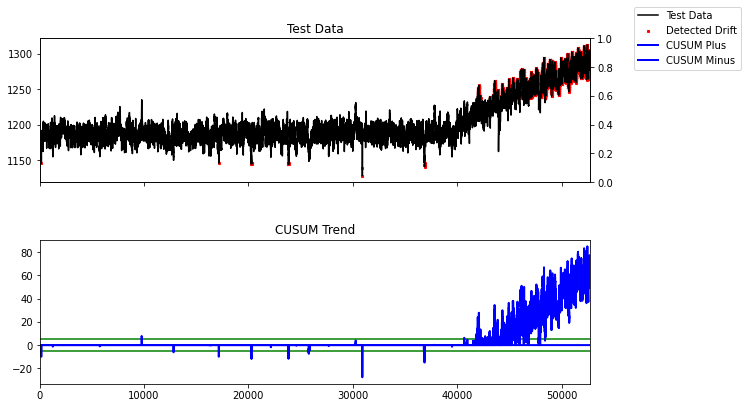

In [8]:
# 시각화
import matplotlib.pyplot as plt
test_data_list = list(test_data[test_tag_list].values.flatten())

fig, ax = plt.subplots(2,1, figsize=(9, 6), sharex=True)
ax1, ax2 = ax[0], ax[1]
ax12 = ax1.twinx()

ax1.plot(test_data_list, c='k', label='Test Data')
ax1.scatter(x=np.arange(len(detecteds)), y=detecteds, 
            s=5.5, c='r', marker='x',
            label='Detected Drift')
ax1.set_xlim(0, len(test_data_list))
ax1.set_title("Test Data")

ax2.axhline(y=5, c='g')
ax2.axhline(y=-5, c='g')
ax2.plot(cusum_plus_list, c='b', label='CUSUM Plus', linewidth=2)
ax2.plot(cusum_minus_list, c='b', label='CUSUM Minus', linewidth=2)
ax2.set_title("CUSUM Trend")

fig.legend(loc='center', bbox_to_anchor=(1.10, 0.9))  # Set the legend location
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.95, hspace=0.4)
plt.show();